In [1]:
import os, sys, numpy as np, time, random, concurrent.futures
import matplotlib.pyplot as plt

# Set up source paths (adjust as necessary)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including markovian ones) from files.
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [14]:
# Define parameters
time_steps = list(range(5, 51, 5))  # T = 5, 10, 15, ..., 50
n_runs = 10
sample_size = 200000
grid_size = 0.1

In [15]:
# Initialize lists to store benchmark values and experimental results.
true_AW_list = []
avg_comp_time = []
std_comp_time = []
avg_error = []
std_error = []
avg_AW = []
std_AW = []

# Function to build the integrated process matrix (nonstationary)
def integrated_process_matrix(T, variance):
    """
    Returns a lower-triangular matrix for an integrated process.
    Each entry is sqrt(variance) and the process is cumulative.
    """
    return np.tril(np.ones((T, T))) * np.sqrt(variance)

# Function to build the AR(1) process Cholesky matrix (stationary)
def ar1_cholesky_matrix(T, phi, sigma):
    """
    Returns a lower-triangular matrix L such that L L^T equals the AR(1)
    covariance matrix with covariance
      Sigma_{ij} = (sigma^2/(1-phi**2))*phi**(|i-j|).
    The first column corresponds to the initial condition drawn from the
    stationary distribution.
    """
    L = np.zeros((T, T))
    for t in range(T):
        for j in range(t+1):
            if j == 0:
                L[t, j] = sigma * (phi**t) / np.sqrt(1 - phi**2)
            else:
                L[t, j] = sigma * (phi**(t - j))
    return L


# Sample size for path generation (assumed defined)
sample_size_plot = 100

# Parameters for the integrated process:
var_X = 0.25   # variance parameter for process X
var_Y = 0.5    # variance parameter for process Y

# Parameters for the AR(1) process:
phi = 0.8      # AR(1) coefficient (|phi| < 1 for stationarity)
sigma_ar1 = 1.0  # scale parameter (innovation std dev)

# Lists to store benchmark (true) adapted Wasserstein squared distances.
# Each entry is a tuple: (integrated_process_AW, ar1_process_AW)
true_AW_list = []

# Fixed seed for reproducibility
fixed_seed = 42

for T in time_steps:
    print(f"\n=== Running experiments for T = {T} ===")
    
    
    # --- AR(1) Process Matrices ---
    L_X_ar1 = ar1_cholesky_matrix(T, phi, sigma_ar1)
    # For illustration, we use the same AR(1) parameters for both X and Y.
    # You could also use different parameters if desired.
    L_Y_ar1 = ar1_cholesky_matrix(T, 0.1, 3)

    print(L_X_ar1)
    print(L_Y_ar1)
    

    
    # For the AR(1) process:
    X_ref_ar1, A = Lmatrix2paths(L_X_ar1, sample_size_plot, seed=fixed_seed, verbose=False)
    Y_ref_ar1, B = Lmatrix2paths(L_Y_ar1, sample_size_plot, seed=fixed_seed, verbose=False)
    

    true_val = adapted_wasserstein_squared(A, B)
    
    print("AR(1) process AW squared distance:", true_val)
    
    # Store the benchmark values
    true_AW_list.append(true_val)

    
    # -----------------------------------------------------
    # Run experiments with the Markovian solver for current T.
    # -----------------------------------------------------
    comp_times = []
    errors = []
    AW_values = []
    
    for run in range(n_runs):
        seed = np.random.randint(10000)
        X, _ = Lmatrix2paths(L_X_ar1, sample_size, seed=seed, verbose=False)
        Y, _ = Lmatrix2paths(L_Y_ar1, sample_size, seed=seed, verbose=False)
        
        adaptedX = path2adaptedpath(X, delta_n=grid_size)
        adaptedY = path2adaptedpath(Y, delta_n=grid_size)
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Compute the adapted Wasserstein distance with the Markovian solver.
        mu_x_m = qpath2mu_x(qX, markovian=True)
        nu_y_m = qpath2mu_x(qY, markovian=True)
        (mu_x_c_m, mu_x_cn_m, mu_x_v_m, mu_x_w_m, mu_x_cumn_m, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x_m, q2v)
        (nu_y_c_m, nu_y_cn_m, nu_y_v_m, nu_y_w_m, nu_y_cumn_m, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y_m, q2v)
        
        t0 = time.perf_counter()
        AW_m = nested2_parallel_markovian(mu_x_cn_m, mu_x_v_m, mu_x_w_m, mu_x_idx,
                                          nu_y_cn_m, nu_y_v_m, nu_y_w_m, nu_y_idx,
                                          n_processes=42)
        t_m = time.perf_counter() - t0
        
        comp_times.append(t_m)
        AW_values.append(AW_m)
        errors.append(abs(AW_m - true_val))
        
        print(f"T = {T}, Run {run+1}: AW_m = {AW_m:.4f}, Time = {t_m:.4f}s, Error = {abs(AW_m - true_val):.4f}")
    
    avg_comp_time.append(np.mean(comp_times))
    std_comp_time.append(np.std(comp_times))
    avg_error.append(np.mean(errors))
    std_error.append(np.std(errors))
    avg_AW.append(np.mean(AW_values))
    std_AW.append(np.std(AW_values))  



=== Running experiments for T = 5 ===
[[1.66666667 0.         0.         0.         0.        ]
 [1.33333333 1.         0.         0.         0.        ]
 [1.06666667 0.8        1.         0.         0.        ]
 [0.85333333 0.64       0.8        1.         0.        ]
 [0.68266667 0.512      0.64       0.8        1.        ]]
[[3.01511345e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.01511345e-01 3.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.01511345e-02 3.00000000e-01 3.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.01511345e-03 3.00000000e-02 3.00000000e-01 3.00000000e+00
  0.00000000e+00]
 [3.01511345e-04 3.00000000e-03 3.00000000e-02 3.00000000e-01
  3.00000000e+00]]
AR(1) process AW squared distance: 22.899274061355015
T = 5, Run 1: AW_m = 22.9288, Time = 6.3903s, Error = 0.0295
T = 5, Run 2: AW_m = 22.9210, Time = 6.5081s, Error = 0.0217
T = 5, Run 3: AW_m = 22.9640, Time = 6.5485s, Error = 0.0647
T = 5, Run 4: AW_m = 22.9686, Ti

Process ForkProcess-82681:
Process ForkProcess-82685:
Process ForkProcess-82695:
Process ForkProcess-82680:
Process ForkProcess-82693:
Process ForkProcess-82696:
Process ForkProcess-82687:
Process ForkProcess-82697:
Process ForkProcess-82678:
Process ForkProcess-82690:
Process ForkProcess-82683:
Process ForkProcess-82694:
Process ForkProcess-82677:
Process ForkProcess-82682:
Process ForkProcess-82689:
Process ForkProcess-82691:
Process ForkProcess-82684:
Process ForkProcess-82686:
Process ForkProcess-82692:
Process ForkProcess-82688:
Process ForkProcess-82679:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2

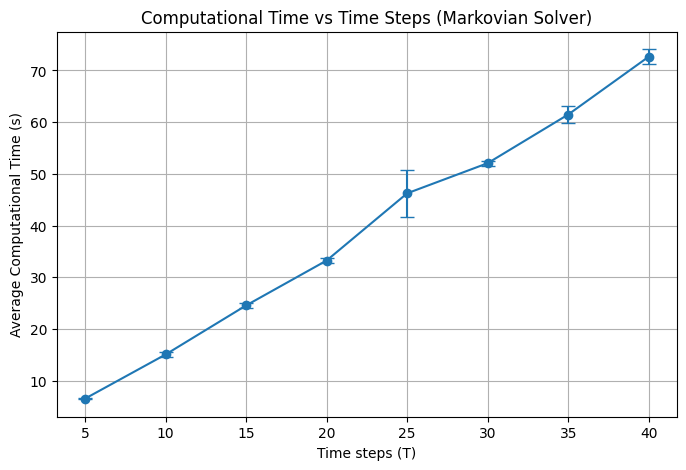

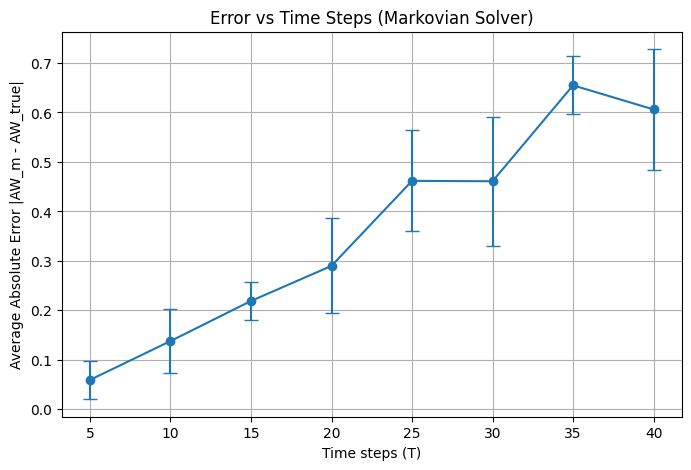

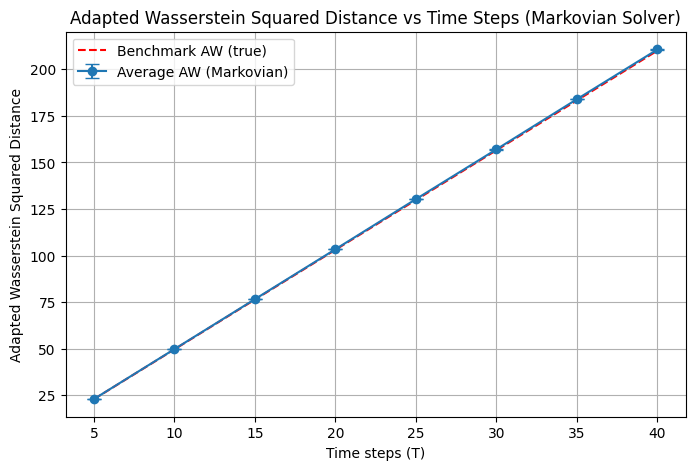

In [23]:
# ---------------------------
# Plot the results
# ---------------------------


# 1. Plot average computational time vs. T with error bars.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps[0:8], avg_comp_time, yerr=std_comp_time, fmt='o-', capsize=5)
plt.xlabel("Time steps (T)")
plt.ylabel("Average Computational Time (s)")
plt.title("Computational Time vs Time Steps (Markovian Solver)")
plt.grid(True)
plt.show()

# 2. Plot average absolute error vs. T with error bars.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps[0:8], avg_error, yerr=std_error, fmt='o-', capsize=5)
plt.xlabel("Time steps (T)")
plt.ylabel("Average Absolute Error |AW_m - AW_true|")
plt.title("Error vs Time Steps (Markovian Solver)")
plt.grid(True)
plt.show()

# 3. Plot average adapted Wasserstein squared distance vs. T with error bars,
#    along with the benchmark (true) value as a dashed line.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps[0:8], avg_AW, yerr=std_AW, fmt='o-', capsize=5, label="Average AW (Markovian)")
plt.plot(time_steps[0:8], true_AW_list[0:8], 'r--', label="Benchmark AW (true)")
plt.xlabel("Time steps (T)")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Adapted Wasserstein Squared Distance vs Time Steps (Markovian Solver)")
plt.legend()
plt.grid(True)
plt.show()